# Conditional survival curves for Weibull distributions

Standard survival curves are most useful when the unit of investigation has just<br>
started being tracked. They don't give the right survival estimates when we already<br>
know that the unit of investigation has *already* survived up to a certain point.<br>
For that we need conditional survival curves. This file shows how to derive<br>
conditional survival curves based on the Weibull distribution, using both<br>
parametric and non-parametric approaches.

References:<br>
[Conditional Survival: A Useful Concept to Provide Information on How Prognosis Evolves over Time](https://aacrjournals.org/clincancerres/article/21/7/1530/248476/Conditional-Survival-A-Useful-Concept-to-Provide)  # noqa

### Todo:

1. Add type hints for function inputs and outputs

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from pathlib import Path

In [2]:
from IPython.core.interactiveshell import InteractiveShell

In [3]:
InteractiveShell.ast_node_interactivity = "all"

# Functions

## Nonparametric approach

In [4]:
def generate_weibull_km_nonparametric(shape_param):
    # Generate uncensored Weibull rvs:
    x = weibull_min.rvs(shape_param, size=1000)
    df = pd.DataFrame({"values": x, "is_uncensored": np.ones_like(x)})
    kmf = KaplanMeierFitter()
    kmf.fit(df["values"], df["is_uncensored"])
    df_km = kmf.survival_function_.copy()
    return df_km.index.values, df_km["KM_estimate"], kmf

In [5]:
def generate_conditional_weibull_km_nonparametric(
    unconditional_km: pd.DataFrame, survived_up_to_quantile: float
):
    df_km = unconditional_km

    # Pick a specific value for s, the time that we have already survived.
    survived_up_to = np.quantile(df_km.index, survived_up_to_quantile)
    survived_up_to_round = round(survived_up_to, 3)

    # Pull the unconditional KM estimate at s - i.e. S_hat(s)
    unconditional_surv_s = df_km.loc[survived_up_to].values[0]

    # Create new col with conditional KM values:
    df_km[f"CS(t|s={survived_up_to_round})"] = (
        df_km["KM_estimate"] / unconditional_surv_s
    )

    # correct for cases where KM value is > 1.0
    df_km[f"CS(t|s={survived_up_to_round})"] = np.where(
        df_km[f"CS(t|s={survived_up_to_round})"] <= 1.0,
        df_km[f"CS(t|s={survived_up_to_round})"],
        1.0,
    )
    return df_km.index.values, df_km[f"CS(t|s={survived_up_to_round})"], survived_up_to

## Parametric approach

In [6]:
def generate_weibull_survival_fn(shape_param):
    x_values = set_up_data(shape_param)
    km_values = weibull_survival_fn(x_values, shape_param)
    return x_values, km_values

In [7]:
def generate_conditional_weibull_survival_fn(shape_param, survived_up_to):
    x_values = set_up_data(shape_param)
    km_values = weibull_survival_fn_conditional(x_values, shape_param, survived_up_to)
    return x_values, km_values

In [8]:
def set_up_data(shape_param):
    x_values = np.linspace(
        weibull_min.ppf(0.01, shape_param), weibull_min.ppf(0.99, shape_param), 100
    )
    return x_values

In [9]:
def weibull_survival_fn(x_values: np.array, shape_param: float) -> np.array:
    surv_fn__values = np.exp(-1 * (x_values**shape_param))
    return surv_fn__values

In [10]:
def weibull_survival_fn_conditional(
    x_values: np.array, shape_param: float, survived_up_to: float
) -> np.array:
    """
    Generate conditional survival estimates
    :param x_values: points to evaluate the conditional km curve on
    :param shape_param: shape param
    :param survived_up_to: time value that we condition on: i.e. we assume survival up
      to this time
    :return:
    """
    survival_fn_value_at_s = np.exp(-1 * (survived_up_to**shape_param))
    all_km_values_unclipped = (
            np.exp(-1 * (x_values**shape_param)) / survival_fn_value_at_s
    )
    all_km_values = np.where(all_km_values_unclipped <= 1, all_km_values_unclipped, 1)
    return all_km_values

In [11]:
def get_median_survival_time(x_values: np.array, surv_values: np.array):
    """
    Picks the last time before the 51st percentile of survival times
    :param x_values:
    :param surv_values: either KM estimator values, or parametric survival function
      values
    :return:
    """
    df = pd.DataFrame({"KM_estimate": surv_values}, index=x_values)
    df.index.name = "timeline"
    median_surv = (df["KM_estimate"][df["KM_estimate"] > 0.50]).index.values[-1]
    return median_surv

# Main analysis

- first set up non-parametric case data<br>
- then set up parametric case data<br>
- then show result plots for each case

In [12]:
save_dir = Path(
    r"\\nos\data\MP_ITAR_Programs\C-17\06_personal-folders\NA\2022-09-20_c17_"
    + r"conditional-survival-based-median-survival-time\dst"
)
rewrite_outputs = False

In [13]:
shape_param = 1.75  # todo: for simplicity, assume scale is always 1

Text(0.5, 1.0, 'Weibull pdf; c = 1.75')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


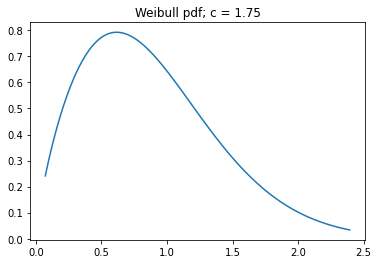

In [14]:
ticks = np.linspace(
    weibull_min.ppf(0.01, shape_param), weibull_min.ppf(0.99, shape_param), 100
)
fig, ax = plt.subplots()
ax.plot(ticks, weibull_min.pdf(ticks, shape_param))
ax.set_title(f"Weibull pdf; c = {shape_param}")
fig.show()

## Nonparametric approach

In [15]:
(
    x_values01,
    km_values_unconditional_nonparametric,
    kmf,
) = generate_weibull_km_nonparametric(shape_param)

In [16]:
median_surv_time_unconditional_nonparametric = get_median_survival_time(
    x_values01, km_values_unconditional_nonparametric
)

In [17]:
survived_up_to_quantile = 0.80  # todo: arbitrary value
(
    x_values02,
    km_values_conditional_nonparametric,
    survived_up_to,
) = generate_conditional_weibull_km_nonparametric(pd.DataFrame(
    {"KM_estimate": km_values_unconditional_nonparametric}, index=x_values01
), survived_up_to_quantile=survived_up_to_quantile)

In [18]:
median_surv_time_conditional_nonparametric = get_median_survival_time(
    x_values02, km_values_conditional_nonparametric
)

In [19]:
survived_up_to_round = round(survived_up_to, 3)

## Parametric approach

In [20]:
x_values, km_values = generate_weibull_survival_fn(shape_param)

In [21]:
median_surv_time_unconditional_parametric = get_median_survival_time(
    x_values, km_values
)

For comparability, use the same value of s that we got for the nonparametric case

In [22]:
x_values, km_values_conditional = generate_conditional_weibull_survival_fn(
    shape_param, survived_up_to
)

In [23]:
median_surv_time_conditional_parametric = get_median_survival_time(
    x_values, km_values_conditional
)

## Plot comparison of parametric vs non-parametric

<AxesSubplot:xlabel='timeline'>

Text(0.0, 1.0, 'Comparing parametric Weibull survival function with KM estimate')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


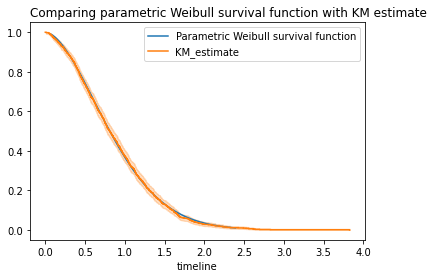

In [24]:
text = "Comparing parametric Weibull survival function with KM estimate"
fig, ax3 = plt.subplots()
ax3.plot(x_values, km_values, label="Parametric Weibull survival function")
kmf.plot_survival_function(ax=ax3)
ax3.set_title(text, loc="left")
ax3.legend()
if rewrite_outputs:
    plt.savefig(save_dir.joinpath("01_parametric-vs-non-parametric.jpg"))
fig.show()

## Plot non-parametric condition and unconditional survival curves

Text(0.0, 1.0, '$\\bf{Unconditional \\ and \\ conditional \\ Weibull \\ survival \\ functions}$\n\n- S(t) represents unconditional survival probability at time t  \n- CS(t|s) represents conditional survival over the next t time-units, \n    given that you have already survived up to s')

Text(1.3551350936311217, -0.01, 's = 1.305')

Text(0.8085125457339246, 0.51, '(0.809, 0.5)')

Text(1.5955133002491888, 0.51, '(1.596, 0.5)')

Text(0.5, 0, 'Time from start')

Text(0, 0.5, 'Survival probability')

(0.0, 3.5)

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


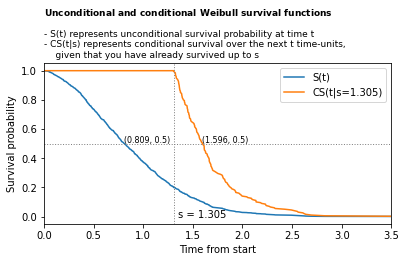

In [25]:
fig, ax1 = plt.subplots()
ax1.plot(x_values01, km_values_unconditional_nonparametric, label="S(t)")
ax1.plot(
    x_values02,
    km_values_conditional_nonparametric,
    label=f"CS(t|s={survived_up_to_round})",
)
font = matplotlib.font_manager.FontProperties(family="Roboto", weight="regular", size=9)
text = r"$\bf{Unconditional \ and \ conditional \ Weibull \ survival \ functions}$"
text += "\n\n"
text += "- S(t) represents unconditional survival probability at time t  \n"
text += "- CS(t|s) represents conditional survival over the next t time-units, \n"
text += "    given that you have already survived up to s"
ax1.set_title(text, loc="left", fontproperties=font)
ax1.axvline(x=survived_up_to, lw=1, ls="dotted", color="grey")
ax1.axhline(y=0.50, lw=1, ls="dotted", color="grey")
ax1.annotate(
    f"s = {survived_up_to_round}",
    xy=(survived_up_to, 0),
    xytext=(survived_up_to + 0.05, -0.01),
)
ax1.annotate(
    f"({round(median_surv_time_unconditional_nonparametric, 3)}, 0.5)",
    xy=(median_surv_time_unconditional_nonparametric, 0.5),
    xytext=(median_surv_time_unconditional_nonparametric, 0.5 + 0.01),
    size=8,
)
ax1.annotate(
    f"({round(median_surv_time_conditional_nonparametric, 3)}, 0.5)",
    xy=(median_surv_time_conditional_nonparametric, 0.5),
    xytext=(median_surv_time_conditional_nonparametric, 0.5 + 0.01),
    size=8,
)
ax1.legend()
ax1.set_xlabel("Time from start")
ax1.set_ylabel("Survival probability")
ax1.set_xlim((0, 3.5))  # todo: adjust if necessary
fig.tight_layout(pad=2)
if rewrite_outputs:
    plt.savefig(save_dir.joinpath("02_non-parametric.jpg"))
fig.show()

## Plot parametric condition and unconditional survival curves

Text(0.0, 1.0, '$\\bf{Parametric \\ conditional \\ and \\ unconditional \\ Weibull \\ survival \\ }$$\\bf{functions}$\n\n- S(t) represents unconditional survival probability at time t  \n- CS(t|s) represents conditional survival over the next t time-units, \n    given that you have already survived up to s')

Text(1.3551350936311217, -0.01, 's = 1.305')

Text(0.7989928381014926, 0.51, '(0.799, 0.5)')

Text(1.5961475022250675, 0.51, '(1.596, 0.5)')

(0.0, 3.5)

Text(0.5, 0, 'Time from start')

Text(0, 0.5, 'Survival probability')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


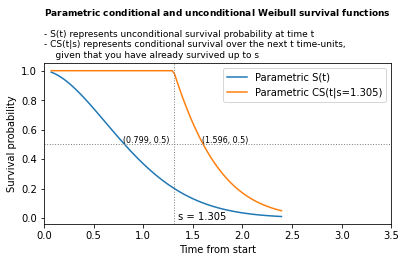

In [26]:
fig, ax2 = plt.subplots()
ax2.plot(x_values, km_values, label="Parametric S(t)")
ax2.plot(
    x_values,
    km_values_conditional,
    label=f"Parametric CS(t|s={survived_up_to_round})",
)
font = matplotlib.font_manager.FontProperties(family="Roboto", weight="regular", size=9)
text = r"$\bf{Parametric \ conditional \ and \ unconditional \ Weibull \ survival \ }$"
text += r"$\bf{functions}$"
text += "\n\n"
text += "- S(t) represents unconditional survival probability at time t  \n"
text += "- CS(t|s) represents conditional survival over the next t time-units, \n"
text += "    given that you have already survived up to s"
ax2.set_title(text, loc="left", fontproperties=font)
ax2.axvline(x=survived_up_to, lw=1, ls="dotted", color="grey")
ax2.axhline(y=0.50, lw=1, ls="dotted", color="grey")
ax2.annotate(
    f"s = {survived_up_to_round}",
    xy=(survived_up_to, 0),
    xytext=(survived_up_to + 0.05, -0.01),
)
ax2.annotate(
    f"({round(median_surv_time_unconditional_parametric, 3)}, 0.5)",
    xy=(median_surv_time_unconditional_parametric, 0.5),
    xytext=(median_surv_time_unconditional_parametric, 0.5 + 0.01),
    size=8,
)
ax2.annotate(
    f"({round(median_surv_time_conditional_parametric, 3)}, 0.5)",
    xy=(median_surv_time_conditional_parametric, 0.5),
    xytext=(median_surv_time_conditional_parametric, 0.5 + 0.01),
    size=8,
)
ax2.legend()
ax2.set_xlim((0, 3.5))  # todo: adjust if necessary
ax2.set_xlabel("Time from start")
ax2.set_ylabel("Survival probability")
fig.tight_layout(pad=2)
if rewrite_outputs:
    plt.savefig(save_dir.joinpath("03_parametric.jpg"))
fig.show()

## Plotting several parametric conditional survival functions:

In [27]:
results = {}
for survived_up_to in np.arange(0.1, 1.5, 0.1):
    x_values_temp, km_values_temp = generate_conditional_weibull_survival_fn(
        shape_param, survived_up_to
    )
    results[survived_up_to] = (x_values_temp, km_values_temp)

plots:

Text(0.0, 1.0, 'Parametric conditional survival functions  \nWeibull shape = 1.75')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


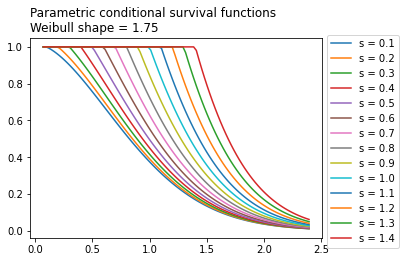

In [28]:
text = f"Parametric conditional survival functions  \nWeibull shape = {shape_param}"
fig, ax = plt.subplots()
for key, value in results.items():
    ax.plot(value[0], value[1], label=f"s = {round(key, 2)}")
ax.set_title(text, loc="left")
ax.legend(bbox_to_anchor=(1, 1.04))
fig.tight_layout(pad=2)
if rewrite_outputs:
    plt.savefig(save_dir.joinpath("04_multiple-parametric.jpg"))
fig.show()